### Import the necessary packages and modules

In [1]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K

%matplotlib inline

### The VAE is trained on fda.csv available at https://zinc.docking.org/substances/subsets/

### Load the drugs dataset for training a VAE

In [2]:
data = pd.read_csv('fda.csv')
data = data.smiles
print(data.shape)

(1615,)


In [3]:
class KLDivergenceLayer(keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)

    def call(self, inputs):
        mu, log_var = inputs
        kl_loss = K.exp(log_var) + K.square(mu) - 1 - log_var
        kl_loss = 0.5*kl_loss
        kl_loss = K.mean(kl_loss)
        self.add_loss(kl_loss, inputs=inputs)
        
        return inputs

class SamplingLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(SamplingLayer, self).__init__(**kwargs)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        z_sigma = K.exp(0.5*z_log_var)
        eps = K.random_normal(shape=(tf.shape(inputs[0])))
        z = z_mean + z_sigma * eps
        return (z_mean, z_sigma, z)

In [6]:
class SmilesVAE():
    def __init__(self,
                 latent_dim,
                 encoder_lstm_units,
                 encoder_hidden_layer_sizes,
                 decoder_lstm_units,
                 decoder_hidden_layer_sizes,
                 epochs,
                 batch_size):
        self.latent_dim = latent_dim
        self.encoder_lstm_units = encoder_lstm_units
        self.decoder_lstm_units = decoder_lstm_units
        self.encoder_hidden_layer_sizes = encoder_hidden_layer_sizes
        self.decoder_hidden_layer_sizes = decoder_hidden_layer_sizes
        self.epochs = epochs
        self.batch_size = batch_size
        
    def __build_vocab__(self, data):
        """
        Build vocabulary from the given dataset
        Also creates a mapping from each character to index and vice-versa
        """
        self.vocab = set("".join(data) + "!E")
        self.vocab_size = len(self.vocab)
        self.max_smiles_length = max([len(s) for s in data]) + 5
        self.char_to_idx = {c: i for i, c in enumerate(self.vocab)}
        self.idx_to_char = {i: c for i, c in enumerate(self.vocab)}
    
    def __vectorize__(self, data):
        """
        Converts SMILES strings to a 2x2 (Max string length, vocabulary size) one-hot encoded matrix.
        The first dimension corresponds to the max string length and second dimension corresponds to an individual character.
        """
        one_hot = np.zeros((data.shape[0], self.max_smiles_length, self.vocab_size), dtype='int')
        for i, smile in enumerate(data):
            one_hot[i, 0, self.char_to_idx['!']] = 1
            for j, c in enumerate(smile):
                one_hot[i, j+1, self.char_to_idx[c]] = 1
            one_hot[i, len(smile)+1:, self.char_to_idx['E']] = 1
        return one_hot
        
    def __build_encoder__(self):
        """
        Builds an encoder model.
        Takes an input string and generates a latent vector.
        """
        input_shape = (self.max_smiles_length - 1, len(self.vocab))
        encoder_inputs = keras.layers.Input(shape=input_shape)

        lstm_output, state_h, state_c = keras.layers.LSTM(self.encoder_lstm_units, return_state=True, unroll=False)(encoder_inputs)
        x = keras.layers.Concatenate(axis=-1)([state_h, state_c])
        for hidden_layer_size in self.encoder_hidden_layer_sizes:
            x = keras.layers.Dense(hidden_layer_size, activation='relu')(x)
        
        z_mean = keras.layers.Dense(self.latent_dim, name='z_mean')(x)
        z_log_var = keras.layers.Dense(self.latent_dim, name='z_log_var')(x)
        z_mean, z_log_var = KLDivergenceLayer(name='KLD')([z_mean, z_log_var])
        z_mean, z_sigma, z = SamplingLayer(name='Sampling')([z_mean, z_log_var])
        
        encoder = keras.Model(encoder_inputs, [z_mean, z_sigma, z], name='encoder')
        self.encoder = encoder
        encoder.summary()
    
    def __build_decoder__(self):
        """
        Build the decoder model.
        Takes a latent vector and returns a reconstructed SMILES string.
        """
        z = keras.layers.Input(shape=(self.latent_dim,))
        decoder_inputs = keras.layers.Input(shape=(self.max_smiles_length - 1, self.vocab_size))
        
        x = z
        for hidden_layer_size in self.decoder_hidden_layer_sizes:
            x = keras.layers.Dense(hidden_layer_size, activation='relu')(x)
        state_h = keras.layers.Dense(self.decoder_lstm_units, activation='relu')(x)
        state_c = keras.layers.Dense(self.decoder_lstm_units, activation='relu')(x)
        
        self.latent_to_states = keras.Model(z, [state_h, state_c])
        
        x = keras.layers.LSTM(self.decoder_lstm_units, return_sequences=True, unroll=False)(decoder_inputs, initial_state=[state_h, state_c])
        decoder_outputs = keras.layers.Dense(self.vocab_size, activation='softmax')(x)
        
        decoder = keras.Model([decoder_inputs, z], decoder_outputs, name='decoder')
        self.decoder = decoder
        decoder.summary()
    
    def __build_VAE__(self):
        """
        Combines the encoder and decoder parts to construct a VAE.
        """
        self.__build_encoder__()
        self.__build_decoder__()
        
        vae_inputs = keras.layers.Input(shape=(self.max_smiles_length - 1, self.vocab_size))
        _, _, z = self.encoder(vae_inputs)
        vae_outputs = self.decoder([vae_inputs, z])
        
        vae = keras.Model(vae_inputs, vae_outputs, name='VAE')
        self.vae = vae
        vae.summary()

    def __vae_loss__(self, x_true, x_pred):
        """
        Loss function for training VAE.
        """
        x_true = K.cast(x_true, 'float')
        x_pred = K.cast(x_pred, 'float')
        const = K.cast(K.shape(x_true)[1], 'float32') * K.cast(K.shape(x_true)[2], 'float32')
        return K.mean(const * K.categorical_crossentropy(x_true, x_pred))

    def __build_sample_model__(self):
        """
        Builds a model similar in structure to the decoder, with the trained decoder weights.
        Instead of returning only the terminal output and states of LSTM cell, it returns the entire sequence of outputs.
        """
        sample_model_inputs = keras.layers.Input(batch_shape=(1, 1, self.vocab_size))
        x = keras.layers.LSTM(self.decoder_lstm_units, return_sequences=True, unroll=False, stateful=True)(sample_model_inputs)
        sample_model_outputs = keras.layers.Dense(self.vocab_size, activation='softmax')(x)
        sample_model = keras.Model(sample_model_inputs, sample_model_outputs)
        
        sample_model.layers[-2].set_weights(self.decoder.layers[-2].get_weights())
        sample_model.layers[-1].set_weights(self.decoder.layers[-1].get_weights())
        
        self.sample_model = sample_model
        self.sample_model.save('sample_model.h5')
        
        
    def train(self, data):
        """
        Trains the VAE for generating SMILES strings
        """
        self.__build_vocab__(data)        
        trainX = self.__vectorize__(data)
        
        np.random.seed(42)
        X = trainX[:, :-1, :]
        Y = trainX[:, 1:, :]
                
        self.__build_VAE__()
        opt = keras.optimizers.Adam(lr=0.005)
        self.vae.compile(optimizer=opt, loss=self.__vae_loss__)
        
        h = keras.callbacks.History()
        print("Starting to train...")
        self.vae.fit(X, 
                     Y,
                     epochs=self.epochs, 
                     batch_size=self.batch_size, 
                     shuffle=True, 
                     callbacks=[h])
        print("Done Training...")
        
        print("Saving models...")
        self.encoder.save("smiles_2_latent.h5")
        self.latent_to_states.save("latent_to_states.h5")   
        self.decoder.save("decoder.h5")
        self.__build_sample_model__()
        print("Done saving models...")

    def sample(self, latent_vec):
        """
        Generates a SMILES string from a given latent vector
        """
        states = self.latent_to_states(latent_vec)
        self.sample_model.layers[1].reset_states(states=[states[0], states[1]])

        smiles_string = ''
        x_input = np.zeros((1, 1, self.vocab_size))
        x_input[0, 0, self.char_to_idx['!']] = 1

        for i in range(vae.max_smiles_length):
            prediction = self.sample_model.predict(x_input)
            char_idx = np.argmax(prediction)
            char_pred = self.idx_to_char[char_idx]
            if char_pred != 'E':
                smiles_string = smiles_string + char_pred
                x_input = np.zeros((1, 1, self.vocab_size))
                x_input[0, 0, char_idx] = 1
            else:
                break

        return smiles_string

In [7]:
vae = SmilesVAE(latent_dim=64,
                encoder_lstm_units=64,
                encoder_hidden_layer_sizes=(64,),
                decoder_lstm_units=64,
                decoder_hidden_layer_sizes=(64,),
                epochs=1000,
                batch_size=256)
vae.train(data)

s/sample - loss: 871.4589
Epoch 787/1000
1615/1615 [==============================] - 0s 198us/sample - loss: 865.5583
Epoch 788/1000
1615/1615 [==============================] - 0s 198us/sample - loss: 861.2673
Epoch 789/1000
1615/1615 [==============================] - 0s 198us/sample - loss: 859.6535
Epoch 790/1000
1615/1615 [==============================] - 0s 206us/sample - loss: 863.2384
Epoch 791/1000
1615/1615 [==============================] - 0s 201us/sample - loss: 865.9699
Epoch 792/1000
1615/1615 [==============================] - 0s 205us/sample - loss: 1505.9968
Epoch 793/1000
1615/1615 [==============================] - 0s 204us/sample - loss: 1373.1352
Epoch 794/1000
1615/1615 [==============================] - 0s 203us/sample - loss: 1233.2758
Epoch 795/1000
1615/1615 [==============================] - 0s 215us/sample - loss: 1124.3840
Epoch 796/1000
1615/1615 [==============================] - 0s 211us/sample - loss: 1044.4037
Epoch 797/1000
1615/1615 [=============

### 

### Creating a set a known molecules i.e. molecules present in the dataset

In [8]:
known_molecules = set()
for smiles in data:
    known_molecules.add(smiles)

### Generate molecules from 100 noise vectors
### [NOTE: Not all generated molecules are valid]

In [9]:
n_mols = 100
sampled_molecules = set()
novel_molecules = set()

for i in range(n_mols):
    print(i)
    z = np.random.randn(1, vae.latent_dim)
    smiles = vae.sample(z)
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        pass
    else:
        if smiles not in sampled_molecules:
            print(smiles)
            sampled_molecules.add(smiles)
        if smiles not in known_molecules:
            novel_molecules.add(smiles)

0

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

CC(=O)N(C[C@H](O)CO)c1c(I)c(C(=O)NCCO)c(I)c(C(=O)NC[C@H](O)CO)c1I
1
2
3
CN(C)CCCc1ccccc1
4
5
6
CC(=O)OCC(=O)[C@@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(C)[C@H]3C(=O)C[C@@]21C
7
8
9
C[C@H](O)CO
10
11
12
13
14
15
N[C@@H](Cc1ccccc1)C(=O)O
16
17
18
19
20
21
22
23
C[C@@H](O)CC(c1ccccc1)c1ccccc1
24
C[C@@H](O)CO
25
26
27
28
29
30
31
CO[C@H]1C[C@@H]2CC[C@@H](C)[C@@](O)(OC(=O)CC)C3CCCCCN3CCCCCN12
32
CC(=O)N(C[C@H](O)CO)c1c(I)c(C(=O)NC[C@H](O)CO)c(I)c(C(=O)NC[C@@H](O)CO)c1I
33
34
35
36
37
38
39
40
Cc1ncnc2ccccc1

### Molecules generated by the VAE

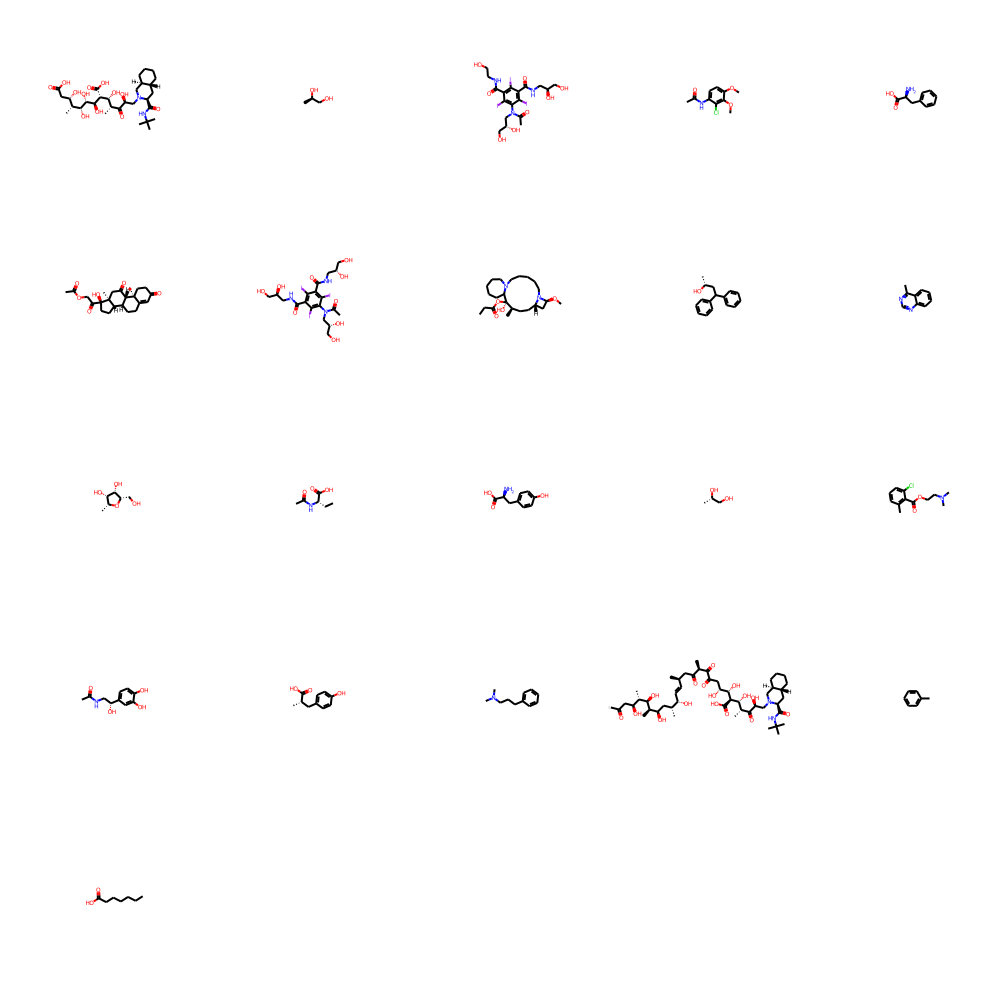

In [10]:
mols = []
for mol in sampled_molecules:
    mols.append(Chem.MolFromSmiles(mol))
Draw.MolsToGridImage(mols, molsPerRow=5)

### Novel molecules generated by the VAE i.e. molecules not seen before by the VAE

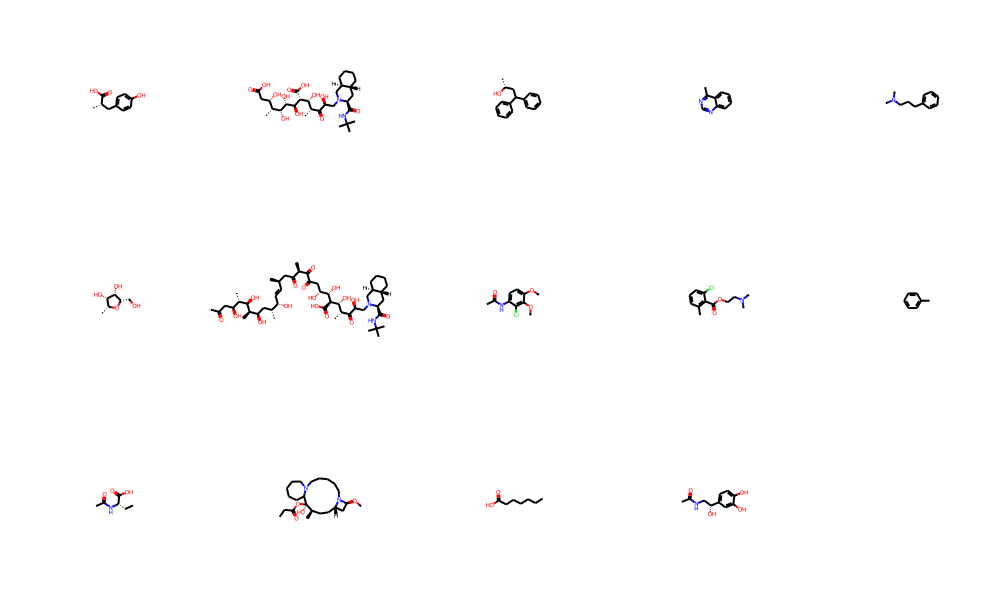

In [11]:
mols = []
for mol in novel_molecules:
    mols.append(Chem.MolFromSmiles(mol))
Draw.MolsToGridImage(mols, molsPerRow=5)